In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Layer, Conv2D, BatchNormalization, Flatten, Conv2DTranspose, Dropout
from tensorflow.keras.initializers import RandomNormal

In [ ]:
NOISE_DIM=100

In [ ]:
EPOCHS=50
BATCH_SIZE=128

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
train_x = train_x/127.5 - 1
test_x = test_x/127.5 - 1

In [ ]:
train_x.min(),train_x.max()

(-1.0, 1.0)

In [ ]:
train_x = train_x.reshape(-1,28*28)

In [ ]:
dataset=tfds.load(name='fashion_mnist', split=tfds.Split.TRAIN)
dataset=dataset.map(lambda x: tf.cast(x['image'], tf.float32) / 127.5 - 1).batch(BATCH_SIZE)

In [ ]:
generator = tf.keras.models.Sequential([
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(28*28, activation='tanh'),
])

In [ ]:
discriminator = tf.keras.models.Sequential([
    Dense(1024, input_shape=(784,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

In [ ]:
optm_g = tf.keras.optimizers.Adam(0.0002,0.5)
optm_d = tf.keras.optimizers.Adam(0.0002, 0.5)

In [ ]:
discriminator.compile(loss='binary_crossentropy',optimizer=optm_d)

In [ ]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

In [ ]:
gan=tf.keras.Model(gan_input,output)
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [ ]:
gan.compile(loss='binary_crossentropy',optimizer=optm_g)

In [ ]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

In [ ]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

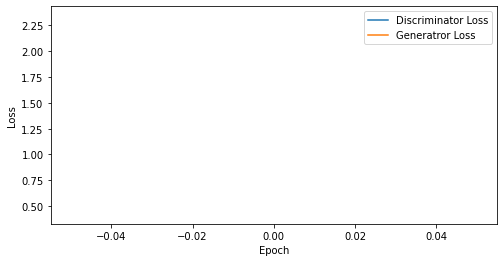

epoch: 1, Discriminator Loss: 0.4239956736564636, Generator Loss: 2.33952260017395


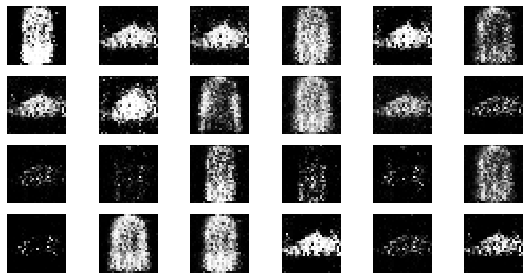

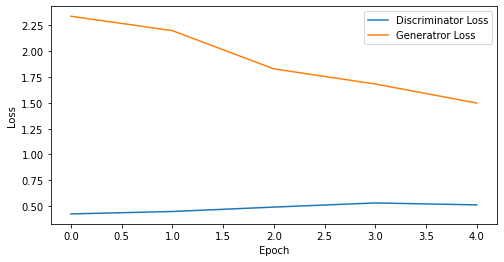

epoch: 5, Discriminator Loss: 0.4806554317474365, Generator Loss: 1.910202980041504


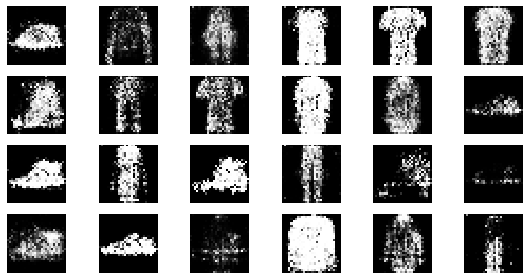

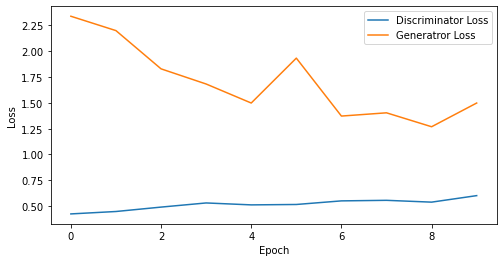

epoch: 10, Discriminator Loss: 0.5164125800132752, Generator Loss: 1.7027950048446656


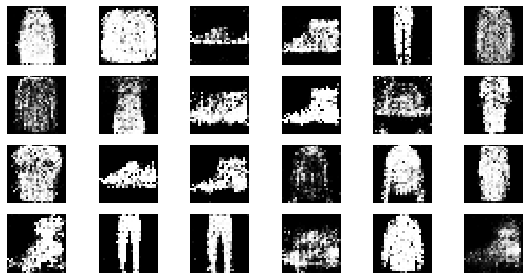

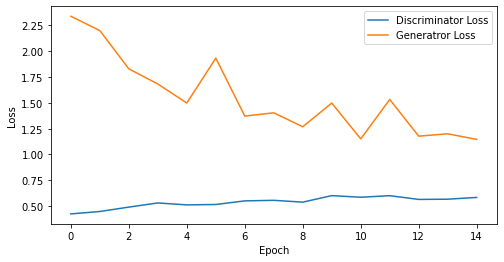

epoch: 15, Discriminator Loss: 0.5376866102218628, Generator Loss: 1.5490736881891887


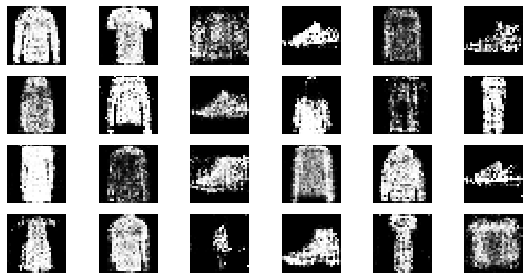

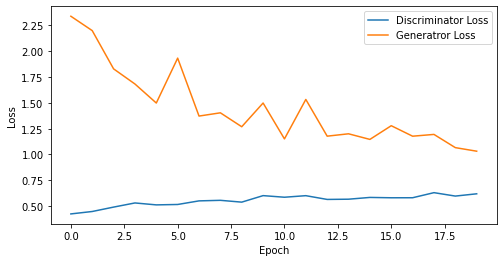

epoch: 20, Discriminator Loss: 0.5536101907491684, Generator Loss: 1.4492220520973205


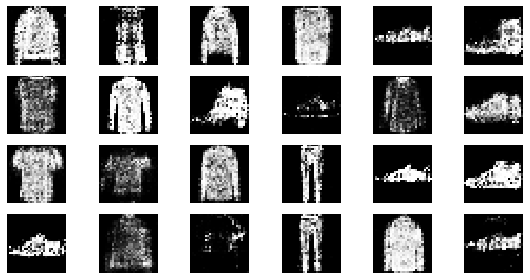

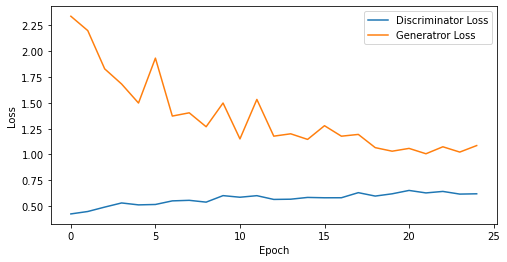

epoch: 25, Discriminator Loss: 0.5691262221336365, Generator Loss: 1.3693771743774414


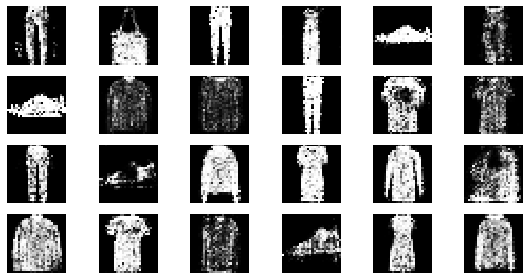

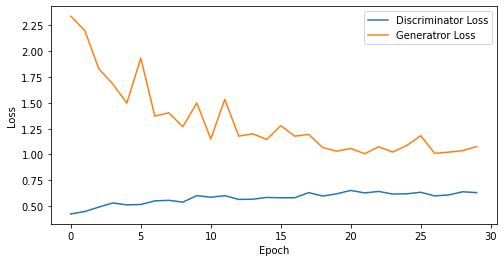

epoch: 30, Discriminator Loss: 0.5779000918070475, Generator Loss: 1.318775753180186


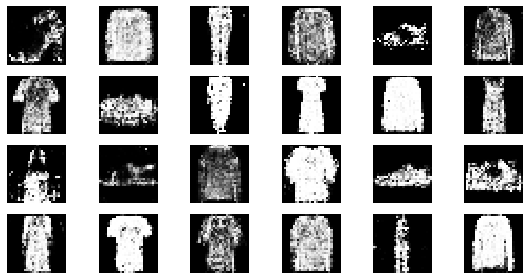

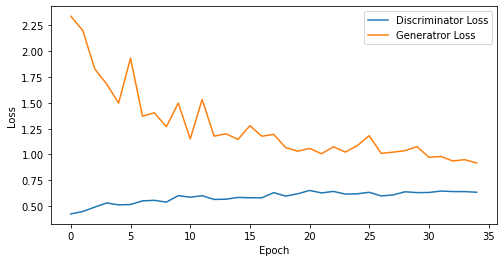

epoch: 35, Discriminator Loss: 0.5865363138062614, Generator Loss: 1.266317277295249


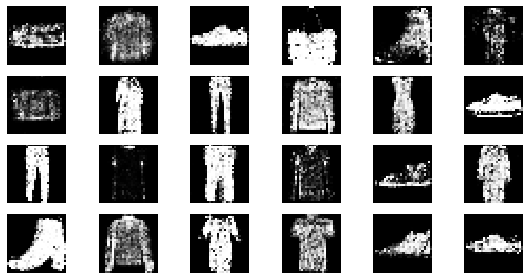

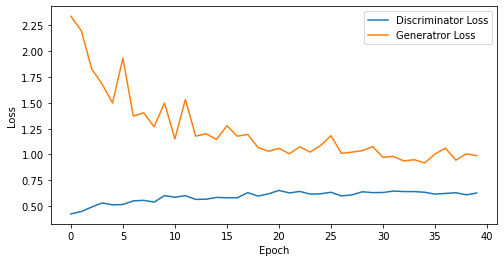

epoch: 40, Discriminator Loss: 0.590791167318821, Generator Loss: 1.2331786170601844


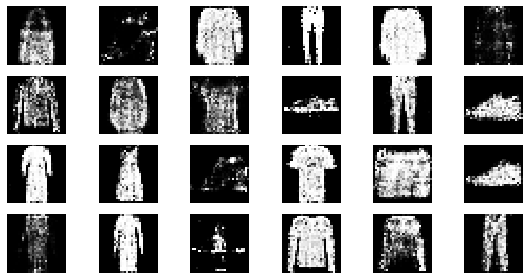

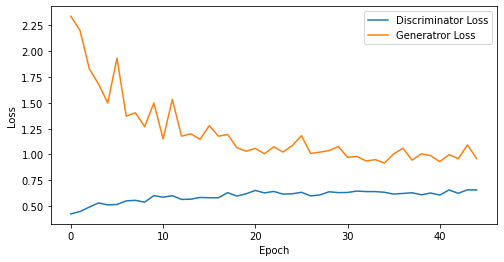

epoch: 45, Discriminator Loss: 0.5962585025363498, Generator Loss: 1.205952889389462


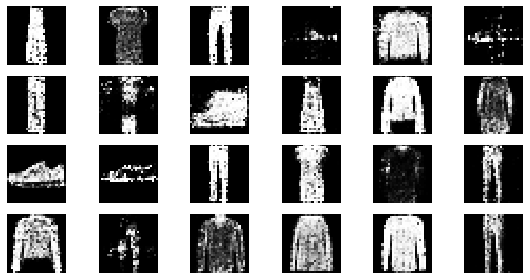

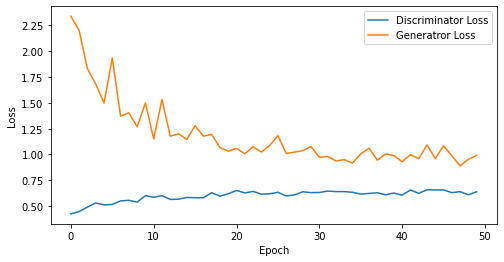

epoch: 50, Discriminator Loss: 0.6001309978961945, Generator Loss: 1.183486888408661


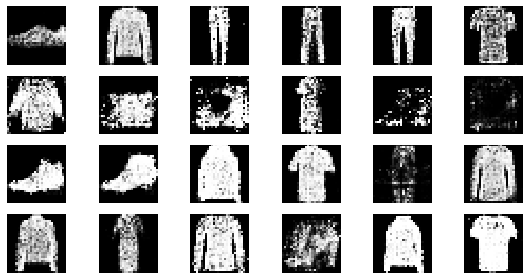

In [ ]:
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(train_x, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_images = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지합니다
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)

In [ ]:
class Generator(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.dense1 = Dense(256,input_shape=(NOISE_DIM,))
    self.LeakyReLU1 = LeakyReLU(0.2)

    self.dense2 = Dense(512)
    self.LeakyReLU2 = LeakyReLU(0.2)

    self.dense3 = Dense(1024)
    self.LeakyReLU3 = LeakyReLU(0.2)

    self.dense4 = Dense(28*28,activation='tanh')

  def call(self, x, training=None, mask=None):
    h=self.LeakyReLU1(self.dense1(x))
    h=self.LeakyReLU2(self.dense2(h))
    h=self.LeakyReLU3(self.dense3(h))
    h=self.dense4(h)

    return h

In [ ]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.dense1 = Dense(1024, kernel_initializer=RandomNormal(stddev=0.02))
    self.LeakyReLU1 = LeakyReLU(0.2)
    self.dropout1= Dropout(0.3)

    self.dense2=Dense(512)
    self.LeakyReLU2 = LeakyReLU(0.2)
    self.dropout2= Dropout(0.3)

    self.dense3=Dense(256)
    self.LeakyReLU3 = LeakyReLU(0.2)
    self.dropout3 = Dropout(0.3)

    self.dense4 = Dense(1,activation='sigmoid')

  def call(self, x, training=None, mask=None):
    h=tf.reshape(x, (-1,28*28))
    h=self.LeakyReLU1(self.dense1(h))
    h=self.dropout1(h)
    h=self.LeakyReLU2(self.dense2(h))
    h=self.dropout2(h)
    h=self.LeakyReLU3(self.dense3(h))
    h=self.dropout3(h)
    h=self.dense4(h)

    return h

In [ ]:
gen = Generator()
disc = Discriminator()

optimizer_g = tf.optimizers.Adam(0.0002,0.5)
optimizer_d = tf.optimizers.Adam(0.0002,0.5)

d_mean = tf.metrics.Mean()
g_mean = tf.metrics.Mean()

In [ ]:
def discriminator_loss(d_real, d_fake):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_real), d_real)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(d_fake), d_fake)
    return real_loss + fake_loss

def generator_loss(d_fake):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_fake), d_fake)

In [ ]:
@tf.function
def train_step(image, optimizer_d, optimizer_g):
    with tf.GradientTape() as tape_d, tf.GradientTape() as tape_g: 
        z = tf.random.normal([128, 100])
        g = gen(z, training=True)
        
        d_real = disc(image, training=True)
        d_fake = disc(g, training=True)
        
        d_loss = discriminator_loss(d_real, d_fake)
        g_loss = generator_loss(d_fake)
        
        gradients_d = tape_d.gradient(d_loss, disc.trainable_weights)
        gradients_g = tape_g.gradient(g_loss, gen.trainable_weights)
    
    optimizer_d.apply_gradients(zip(gradients_d, disc.trainable_weights))
    optimizer_g.apply_gradients(zip(gradients_g, gen.trainable_weights))

    return d_loss, g_loss

epoch: 1, d_loss: 0.694310188293457, g_loss: 1.890965223312378


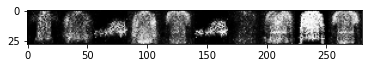

epoch: 2, d_loss: 0.881190836429596, g_loss: 1.5394952297210693
epoch: 3, d_loss: 0.9252233505249023, g_loss: 1.462039828300476
epoch: 4, d_loss: 0.9520859122276306, g_loss: 1.407274603843689
epoch: 5, d_loss: 0.9733464121818542, g_loss: 1.3621965646743774
epoch: 6, d_loss: 0.9888782501220703, g_loss: 1.327010154724121
epoch: 7, d_loss: 1.0290194749832153, g_loss: 1.2444170713424683
epoch: 8, d_loss: 1.052388310432434, g_loss: 1.2015409469604492
epoch: 9, d_loss: 1.0731310844421387, g_loss: 1.169094204902649
epoch: 10, d_loss: 1.1031556129455566, g_loss: 1.1241978406906128
epoch: 11, d_loss: 1.1135270595550537, g_loss: 1.1017143726348877


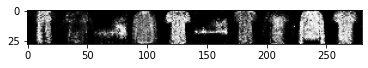

epoch: 12, d_loss: 1.1269901990890503, g_loss: 1.081468939781189
epoch: 13, d_loss: 1.143022894859314, g_loss: 1.052871584892273
epoch: 14, d_loss: 1.1472126245498657, g_loss: 1.0440518856048584
epoch: 15, d_loss: 1.1521239280700684, g_loss: 1.0369620323181152
epoch: 16, d_loss: 1.1586811542510986, g_loss: 1.0230116844177246
epoch: 17, d_loss: 1.1777455806732178, g_loss: 1.0038026571273804
epoch: 18, d_loss: 1.1810036897659302, g_loss: 0.9895638227462769
epoch: 19, d_loss: 1.1848139762878418, g_loss: 0.988040030002594
epoch: 20, d_loss: 1.1998571157455444, g_loss: 0.965065598487854
epoch: 21, d_loss: 1.2053420543670654, g_loss: 0.9543738961219788


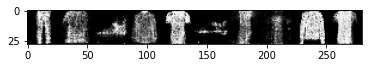

epoch: 22, d_loss: 1.2099535465240479, g_loss: 0.9464064836502075
epoch: 23, d_loss: 1.2169898748397827, g_loss: 0.9404662847518921
epoch: 24, d_loss: 1.2258553504943848, g_loss: 0.930558443069458
epoch: 25, d_loss: 1.2281142473220825, g_loss: 0.9187593460083008
epoch: 26, d_loss: 1.2348045110702515, g_loss: 0.9141463041305542
epoch: 27, d_loss: 1.2347427606582642, g_loss: 0.9118577241897583
epoch: 28, d_loss: 1.2370911836624146, g_loss: 0.9093701243400574
epoch: 29, d_loss: 1.2317743301391602, g_loss: 0.9149790406227112
epoch: 30, d_loss: 1.244526982307434, g_loss: 0.8966699242591858
epoch: 31, d_loss: 1.242553472518921, g_loss: 0.8986009955406189


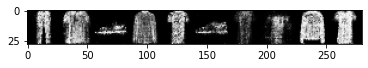

epoch: 32, d_loss: 1.2484043836593628, g_loss: 0.8916303515434265
epoch: 33, d_loss: 1.251640796661377, g_loss: 0.8857019543647766
epoch: 34, d_loss: 1.249621033668518, g_loss: 0.8881351947784424
epoch: 35, d_loss: 1.257477879524231, g_loss: 0.8793197870254517
epoch: 36, d_loss: 1.2489643096923828, g_loss: 0.8869898319244385
epoch: 37, d_loss: 1.2543165683746338, g_loss: 0.8837325572967529
epoch: 38, d_loss: 1.258198857307434, g_loss: 0.8740924596786499
epoch: 39, d_loss: 1.2637345790863037, g_loss: 0.8685653209686279
epoch: 40, d_loss: 1.2572455406188965, g_loss: 0.8773506283760071
epoch: 41, d_loss: 1.2594444751739502, g_loss: 0.8735957145690918


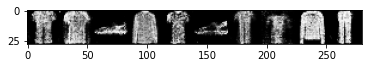

epoch: 42, d_loss: 1.2605270147323608, g_loss: 0.8676027655601501
epoch: 43, d_loss: 1.2634663581848145, g_loss: 0.8646671772003174
epoch: 44, d_loss: 1.2635319232940674, g_loss: 0.8640668392181396
epoch: 45, d_loss: 1.2603873014450073, g_loss: 0.8719533681869507
epoch: 46, d_loss: 1.267391562461853, g_loss: 0.8613379001617432
epoch: 47, d_loss: 1.259631633758545, g_loss: 0.8668584823608398
epoch: 48, d_loss: 1.261972427368164, g_loss: 0.865409791469574
epoch: 49, d_loss: 1.2634462118148804, g_loss: 0.8662689328193665
epoch: 50, d_loss: 1.2614818811416626, g_loss: 0.8658953905105591
epoch: 51, d_loss: 1.2640570402145386, g_loss: 0.8633282780647278


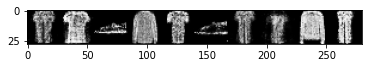

epoch: 52, d_loss: 1.2660108804702759, g_loss: 0.8633835315704346
epoch: 53, d_loss: 1.2609091997146606, g_loss: 0.8688380122184753
epoch: 54, d_loss: 1.2660675048828125, g_loss: 0.8609330058097839
epoch: 55, d_loss: 1.2637594938278198, g_loss: 0.8641868829727173
epoch: 56, d_loss: 1.2654353380203247, g_loss: 0.8600767254829407
epoch: 57, d_loss: 1.2690330743789673, g_loss: 0.8597798347473145
epoch: 58, d_loss: 1.2660609483718872, g_loss: 0.8613642454147339
epoch: 59, d_loss: 1.267789363861084, g_loss: 0.8579915165901184
epoch: 60, d_loss: 1.261814832687378, g_loss: 0.8668739199638367
epoch: 61, d_loss: 1.2661458253860474, g_loss: 0.8607168793678284


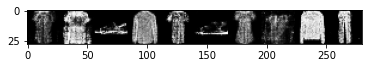

epoch: 62, d_loss: 1.267548680305481, g_loss: 0.8609973788261414
epoch: 63, d_loss: 1.2654260396957397, g_loss: 0.8649331331253052
epoch: 64, d_loss: 1.264176368713379, g_loss: 0.8595535755157471
epoch: 65, d_loss: 1.265669584274292, g_loss: 0.8622161149978638
epoch: 66, d_loss: 1.2625603675842285, g_loss: 0.8630274534225464
epoch: 67, d_loss: 1.2670679092407227, g_loss: 0.8594505190849304
epoch: 68, d_loss: 1.2652415037155151, g_loss: 0.8623961806297302
epoch: 69, d_loss: 1.2619037628173828, g_loss: 0.8663552403450012
epoch: 70, d_loss: 1.2660645246505737, g_loss: 0.8608282208442688
epoch: 71, d_loss: 1.2652485370635986, g_loss: 0.8625569343566895


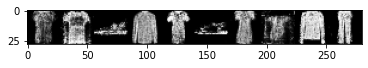

epoch: 72, d_loss: 1.2664905786514282, g_loss: 0.8597859740257263
epoch: 73, d_loss: 1.2659008502960205, g_loss: 0.8620052337646484
epoch: 74, d_loss: 1.2608529329299927, g_loss: 0.8660763502120972
epoch: 75, d_loss: 1.2675725221633911, g_loss: 0.8598639369010925
epoch: 76, d_loss: 1.2641291618347168, g_loss: 0.8625495433807373
epoch: 77, d_loss: 1.26421320438385, g_loss: 0.8619741201400757
epoch: 78, d_loss: 1.2662441730499268, g_loss: 0.8608032464981079
epoch: 79, d_loss: 1.2608879804611206, g_loss: 0.8661724925041199
epoch: 80, d_loss: 1.263176679611206, g_loss: 0.8645514845848083
epoch: 81, d_loss: 1.2622004747390747, g_loss: 0.8655555844306946


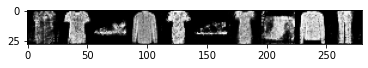

epoch: 82, d_loss: 1.266343355178833, g_loss: 0.863438606262207
epoch: 83, d_loss: 1.2627756595611572, g_loss: 0.8644724488258362
epoch: 84, d_loss: 1.2612403631210327, g_loss: 0.8667334914207458
epoch: 85, d_loss: 1.264076590538025, g_loss: 0.8650858402252197
epoch: 86, d_loss: 1.2575632333755493, g_loss: 0.8698914647102356
epoch: 87, d_loss: 1.2685744762420654, g_loss: 0.8575665354728699
epoch: 88, d_loss: 1.2647157907485962, g_loss: 0.8614640831947327
epoch: 89, d_loss: 1.2634743452072144, g_loss: 0.866427481174469
epoch: 90, d_loss: 1.2640795707702637, g_loss: 0.8602293729782104
epoch: 91, d_loss: 1.2614853382110596, g_loss: 0.8656118512153625


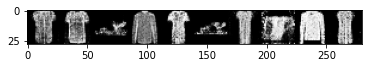

epoch: 92, d_loss: 1.2663862705230713, g_loss: 0.860125720500946
epoch: 93, d_loss: 1.2627928256988525, g_loss: 0.8632238507270813
epoch: 94, d_loss: 1.2632333040237427, g_loss: 0.8643762469291687
epoch: 95, d_loss: 1.2612175941467285, g_loss: 0.8635038137435913
epoch: 96, d_loss: 1.267492413520813, g_loss: 0.8604317307472229
epoch: 97, d_loss: 1.2571977376937866, g_loss: 0.8687492609024048
epoch: 98, d_loss: 1.2654427289962769, g_loss: 0.8618050217628479
epoch: 99, d_loss: 1.2677708864212036, g_loss: 0.8581720590591431
epoch: 100, d_loss: 1.2636290788650513, g_loss: 0.8640561699867249


In [ ]:
sample_z = tf.random.normal([10, NOISE_DIM])
for epoch in range(100):
    for image in dataset:
        d_loss, g_loss = train_step(image, optimizer_d, optimizer_g)

        d_mean.update_state(d_loss)
        g_mean.update_state(g_loss)

    print('epoch: {}, d_loss: {}, g_loss: {}'.format(epoch+1, d_mean.result(), g_mean.result()))
    
    if epoch % 10 == 0:
        img_list = list()
        sample_img = gen(sample_z)
        sample=tf.reshape(sample_img,(-1,28,28))
        for idx in range(sample_img.shape[0]):
          img_list.append(sample[idx])
        img = np.concatenate(img_list, axis=1)
        plt.imshow(img, cmap='gray')
        plt.show()

    d_mean.reset_states()
    g_mean.reset_states()